In [1]:

import torch
from exp.nb_Training import *

In [2]:
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160'

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160')

In [5]:
#export
from pathlib import Path
import PIL,os,mimetypes
Path.ls = lambda x: list(x.iterdir())

In [ ]:
from collections import Counter

In [10]:
#example of pathlib iterdir
Counter(p.suffix for p in Path.cwd().iterdir())

Counter({'.ipynb': 15,
         '': 4,
         '.md': 1,
         '.py': 2,
         '.rar': 1,
         '.mp3': 1,
         '.txt': 1})

In [11]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [12]:
image_extensions

{'.bmp',
 '.gif',
 '.ico',
 '.ief',
 '.jpe',
 '.jpeg',
 '.jpg',
 '.pbm',
 '.pgm',
 '.png',
 '.pnm',
 '.ppm',
 '.ras',
 '.rgb',
 '.svg',
 '.tif',
 '.tiff',
 '.xbm',
 '.xpm',
 '.xwd'}

In [13]:
' '.join(image_extensions)

'.jpg .tif .ppm .pbm .gif .xpm .bmp .pgm .png .jpe .jpeg .svg .xwd .xbm .ras .ief .ico .rgb .tiff .pnm'

In [14]:
#export
def setify(o): return o if isinstance(o,set) else set(listify(o))

In [15]:
path_tench = path/'val'/'n01440764'

In [16]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00018317.JPEG')

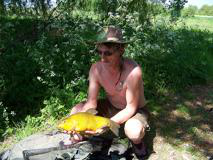

In [17]:
img = PIL.Image.open(img_fn)
img

let's walk through the directories and grab all the images. The first private function grabs all the images inside a given directory and the second one walks (potentially recursively) through all the folder in path.

In [18]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [19]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00018317.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00037383.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00011233.JPEG')]

In [20]:
#recursively scan through the directory for all image files
t = [o.name for o in os.scandir(path_tench)]

In [21]:
t

['ILSVRC2012_val_00018317.JPEG',
 'ILSVRC2012_val_00037383.JPEG',
 'ILSVRC2012_val_00011233.JPEG',
 'ILSVRC2012_val_00011993.JPEG',
 'ILSVRC2012_val_00024327.JPEG',
 'ILSVRC2012_val_00024235.JPEG',
 'ILSVRC2012_val_00026064.JPEG',
 'ILSVRC2012_val_00013716.JPEG',
 'ILSVRC2012_val_00048969.JPEG',
 'ILSVRC2012_val_00037834.JPEG',
 'ILSVRC2012_val_00031333.JPEG',
 'ILSVRC2012_val_00040358.JPEG',
 'ILSVRC2012_val_00003014.JPEG',
 'ILSVRC2012_val_00045880.JPEG',
 'ILSVRC2012_val_00031094.JPEG',
 'ILSVRC2012_val_00039905.JPEG',
 'ILSVRC2012_val_00007197.JPEG',
 'ILSVRC2012_val_00010306.JPEG',
 'ILSVRC2012_val_00017699.JPEG',
 'ILSVRC2012_val_00009111.JPEG',
 'ILSVRC2012_val_00046252.JPEG',
 'ILSVRC2012_val_00041939.JPEG',
 'ILSVRC2012_val_00028158.JPEG',
 'ILSVRC2012_val_00034654.JPEG',
 'ILSVRC2012_val_00009346.JPEG',
 'ILSVRC2012_val_00025527.JPEG',
 'ILSVRC2012_val_00023559.JPEG',
 'ILSVRC2012_val_00046499.JPEG',
 'ILSVRC2012_val_00045866.JPEG',
 'ILSVRC2012_val_00002138.JPEG',
 'ILSVRC20

In [22]:
#grab all the images using the private function. Rememeber _ is just a notation. There are no actual private modifiers in Python
t = _get_files(path, t, extensions=image_extensions)

In [23]:
t

[PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00018317.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00037383.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00011233.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00011993.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00024327.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00024235.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00026064.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00013716.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00048969.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00037834.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/ILSVRC2012_val_00031

In [24]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for p,d,f in os.walk(path): # returns (dirpath, dirnames, filenames)
            if include is not None: d[:] = [o for o in d if o in include]
            else:                   d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [26]:
#os.walk() returns a generator object so it needs to be unpacked by iteration
next(os.walk(path_tench))

('/Users/abhinavverma/.fastai/data/imagenette-160/val/n01440764',
 [],
 ['ILSVRC2012_val_00018317.JPEG',
  'ILSVRC2012_val_00037383.JPEG',
  'ILSVRC2012_val_00011233.JPEG',
  'ILSVRC2012_val_00011993.JPEG',
  'ILSVRC2012_val_00024327.JPEG',
  'ILSVRC2012_val_00024235.JPEG',
  'ILSVRC2012_val_00026064.JPEG',
  'ILSVRC2012_val_00013716.JPEG',
  'ILSVRC2012_val_00048969.JPEG',
  'ILSVRC2012_val_00037834.JPEG',
  'ILSVRC2012_val_00031333.JPEG',
  'ILSVRC2012_val_00040358.JPEG',
  'ILSVRC2012_val_00003014.JPEG',
  'ILSVRC2012_val_00045880.JPEG',
  'ILSVRC2012_val_00031094.JPEG',
  'ILSVRC2012_val_00039905.JPEG',
  'ILSVRC2012_val_00007197.JPEG',
  'ILSVRC2012_val_00010306.JPEG',
  'ILSVRC2012_val_00017699.JPEG',
  'ILSVRC2012_val_00009111.JPEG',
  'ILSVRC2012_val_00046252.JPEG',
  'ILSVRC2012_val_00041939.JPEG',
  'ILSVRC2012_val_00028158.JPEG',
  'ILSVRC2012_val_00034654.JPEG',
  'ILSVRC2012_val_00009346.JPEG',
  'ILSVRC2012_val_00025527.JPEG',
  'ILSVRC2012_val_00023559.JPEG',
  'ILSVRC20

In [27]:
get_files(path_tench, image_extensions)[:3]

[PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00018317.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00037383.JPEG'),
 PosixPath('/Users/abhinavverma/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00011233.JPEG')]

In [28]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

In [29]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

95.3 ms ± 3.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
